## Importing Dataset

In [2]:
!pip install opencv-python

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.6/38.8 MB 7.7 MB/s eta 0:00:05
   -- ------------------------------------- 2.6/38.8 MB 7.6 MB/s eta 0:00:05
   --- ------------------------------------ 3.7/38.8 MB 5.7 MB/s eta 0:00:07
   ----- ---------------------------------- 5.0/38.8 MB 5.9 MB/s eta 0:00:06
   ------ --------------------------------- 6.0/38.8 MB 5.9 MB/s eta 0:00:06
   ------ --------------------------------- 6.6/38.8 MB 5.6 MB/s eta 0:00:06
   ------- -------------------------------- 7.6/38.8 MB 5.2 MB/s eta 0:00:06
   -------- ------------------------------- 8.1/38.8 MB 5.0 MB/s eta 0:00:07
   --------- ------------------------------ 9.4/38.8 MB 5.0 MB/s eta 0:00:06
   ---------- ----------------------------- 10.5/38.8 MB 5.1 MB/s eta 0:00:06
   ------------ --------------------------- 12.3/38.8 MB 5.4 MB/s eta 0:00:05
   -------------- ------------------------- 13.6/38.8 MB 5.5 MB/s eta 0:00:05
   

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Libraries Imported.")

Libraries Imported.


## Loading Data

In [12]:
# Directory for training data

X_Ray_Directory = 'C:/Users/saish/Documents/Case Studies/Operation_Dep_Case_Study/Dataset'

In [13]:
# List of folders train data

os.listdir(X_Ray_Directory)

['0', '1', '2', '3']

In [14]:
# Image generator to generate tensor images data and normalize them
# Using 20% of the data for cross-validation

image_generator = ImageDataGenerator(rescale= 1./255, validation_split = 0.2)

In [15]:
# Generate batches of 40 images
# Total number of images is 133 * 4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory = X_Ray_Directory, shuffle = True,
                                                      target_size = (256,256), class_mode = 'categorical', subset = 'training')

Found 428 images belonging to 4 classes.


In [16]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory = X_Ray_Directory, shuffle = True,
                                                           target_size = (256,256), class_mode = 'categorical', subset = 'validation')

Found 104 images belonging to 4 classes.


In [17]:
# Generate batch of 40 images and 40 labels

train_images, train_labels = next(train_generator)

In [18]:
train_images.shape

(40, 256, 256, 3)

**40 images of 256 pixels by 256 pixels by 3 (colors/channels)**

In [19]:
train_labels.shape

(40, 4)

In [20]:
train_labels

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]],

In [21]:
# Label Translator

label_names = {0: 'Covid-19',
               1: 'Normal',
               2: 'Viral Pneumonia',
               3: 'Bacterial Pneumonia'}

## Visualize Dataset

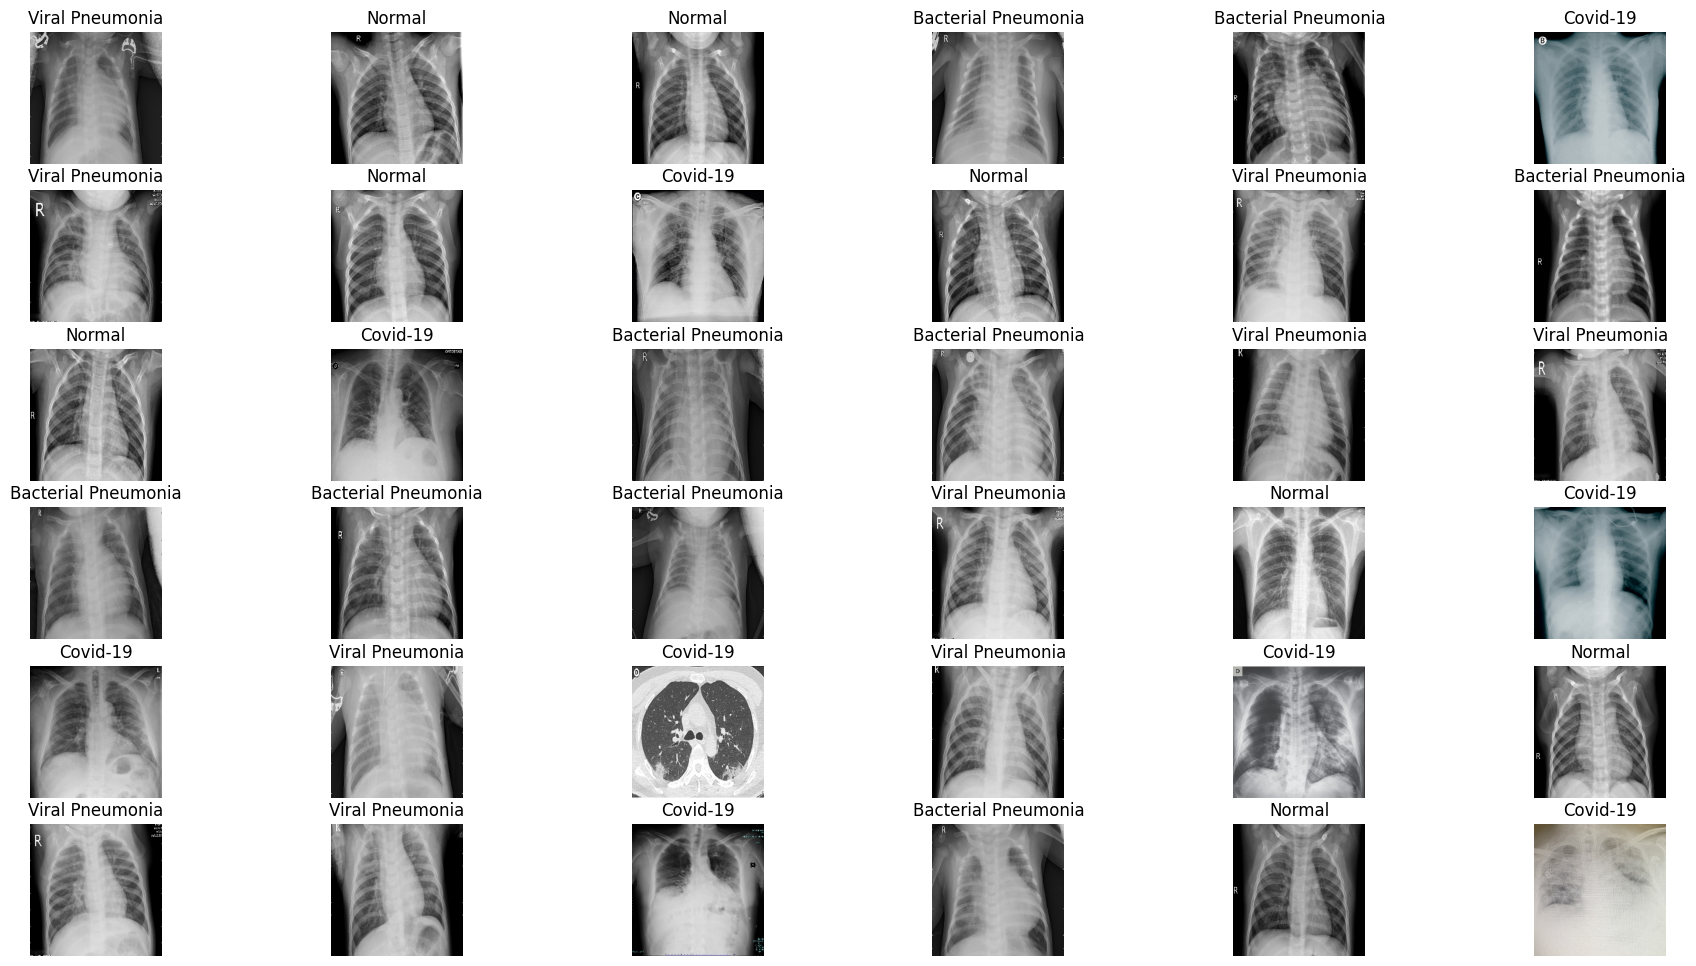

In [23]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (22,12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')
    
plt.subplots_adjust(wspace = 0.5)
plt.show()

## Import Model with Pretrained Weights

In [24]:
basemodel  = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step


In [26]:
# Freezing layers in the model

for layer in basemodel.layers[:-10]:
    layers.trainable = False

## Build and Train Deep Learning Model

In [27]:
headmodel = basemodel.output
# Adding average pooling layer to headmodel
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
# Adding flattening layer to headmodel
headmodel = Flatten(name = 'flatten')(headmodel)
# Adding Dense layer(Artificial Neural Network)
headmodel = Dense(256, activation = 'relu')(headmodel)
# Dropping co dependent neurons to reduce overfitting and generalizing the model
headmodel = Dropout(0.3)(headmodel)
# Adding another dense layer
headmodel = Dense(256, activation = 'relu')(headmodel)
# Another dropout layer
headmodel = Dropout(0.3)(headmodel)
# Dense Layer
headmodel = Dense(4, activation = 'softmax')(headmodel)

In [28]:
# Combining basemodel to newmodel

model = Model(inputs = basemodel.input, outputs = headmodel)

In [35]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

In [ ]:
# EarlyStopping to exit training if validation loss is not decreasing after certain number of epochs (patience) to avoind overfitting
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = 'weights.keras ', verbose = 1, save_best_only = True)

In [32]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True,
                                                      target_size = (256,256), class_mode = 'categorical', subset = 'training')

val_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True,
                                                      target_size = (256,256), class_mode = 'categorical', subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [37]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 4, epochs = 25, validation_data = val_generator, validation_steps = val_generator.n // 4, callbacks = [checkpointer, earlystopping])

Epoch 1/25


c:\Users\saish\Documents\Case Studies\vevn\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\saish\Documents\Case Studies\vevn\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5359 - loss: 1.1701
Epoch 1: val_loss improved from inf to 2.70126, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.5370 - loss: 1.1676 - val_accuracy: 0.2500 - val_loss: 2.7013
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8545 - loss: 0.3888
Epoch 2: val_loss did not improve from 2.70126
107/107 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.8545 - loss: 0.3894 - val_accuracy: 0.2500 - val_loss: 10.8528
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9447 - loss: 0.1782
Epoch 3: val_loss did not improve from 2.70126
107/107 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9444 - loss: 0.1792 - val_accuracy: 0.2500 - val_loss: 9.5994
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9655 - loss: 0.1124
Epoch 4: val_loss did not improve from 2.70126
107/107 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9654 - loss: 0.1129 - val_accuracy: 0.250

## Evaluate Trained Deep Learning Model

In [39]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

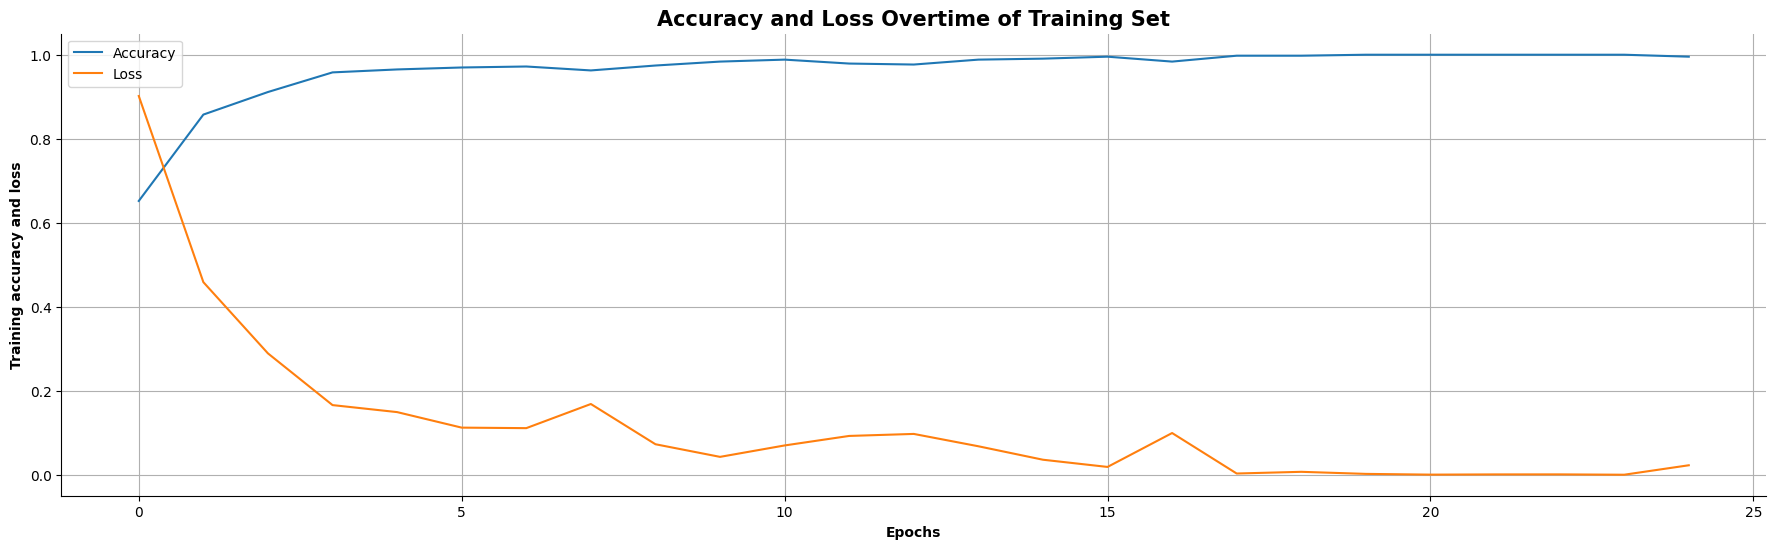

In [50]:
plt.figure(figsize = (22,6))
plt.title("Accuracy and Loss Overtime of Training Set", weight = 'bold', size = 15)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs', weight = 'bold')
plt.ylabel("Training accuracy and loss", weight = 'bold')
plt.grid(True)
plt.legend(['Accuracy','Loss'])
sns.despine()

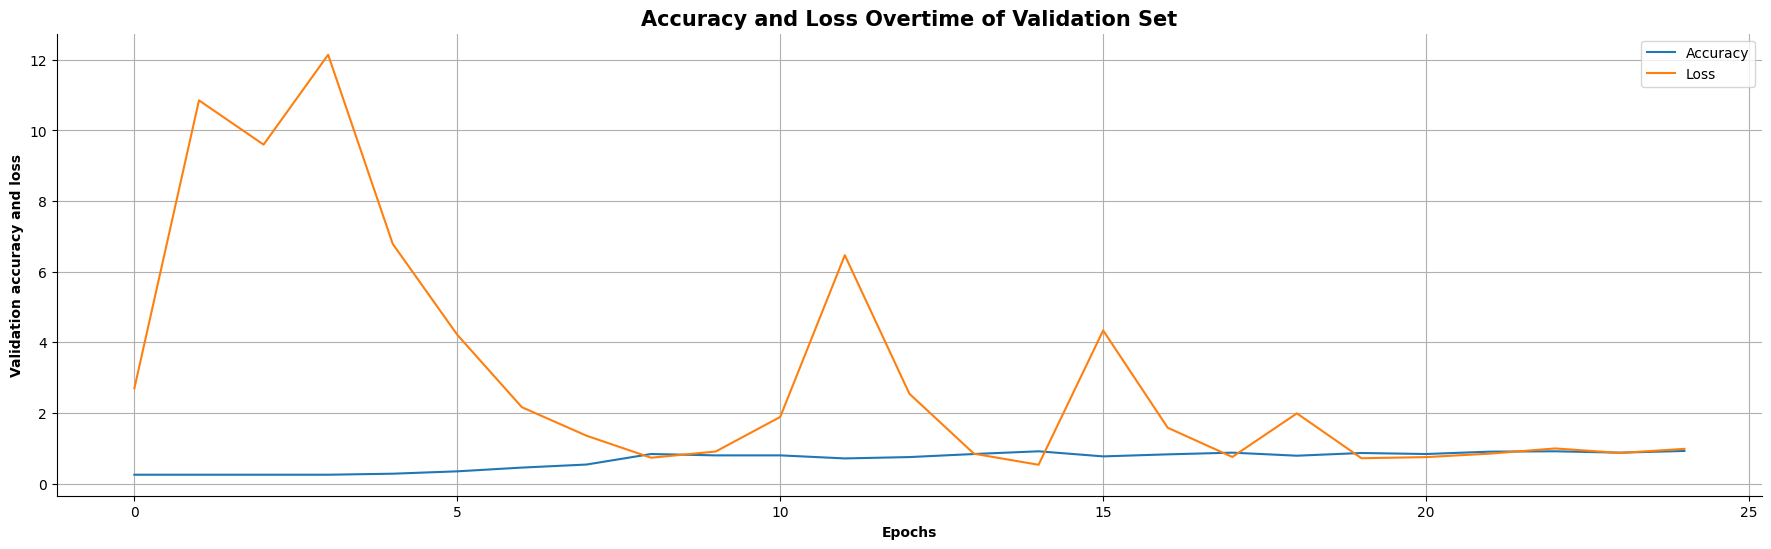

In [54]:
plt.figure(figsize = (22,6))
plt.title("Accuracy and Loss Overtime of Validation Set", weight = 'bold', size = 15)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs', weight = 'bold')
plt.ylabel("Validation accuracy and loss", weight = 'bold')
plt.grid(True)
plt.legend(['Accuracy','Loss'])
sns.despine()

In [59]:
test_directory = 'C:/Users/saish/Documents/Case Studies/Operation_Dep_Case_Study/Test'

In [62]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, shuffle = True, target_size = (256,256),
                                              class_mode = 'categorical')
evaluate = model.evaluate(test_generator, steps = test_generator.n // 4, verbose = 1)
print(f"Test Accuracy: {evaluate[1]}")

Found 40 images belonging to 4 classes.


c:\Users\saish\Documents\Case Studies\vevn\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8250 - loss: 2.1678
Test Accuracy: 0.824999988079071


c:\Users\saish\Documents\Case Studies\vevn\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [63]:
print(f"Test Accuracy: {evaluate[1]}")

Test Accuracy: 0.824999988079071


**Model gave approximately 82.5% accuracy on the test dataset.**

In [65]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1,256,256,3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

c:\Users\saish\Documents\Case Studies\vevn\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [67]:
score = accuracy_score(original, prediction)
print(f"Test Accuracy: {score}")

Test Accuracy: 0.825


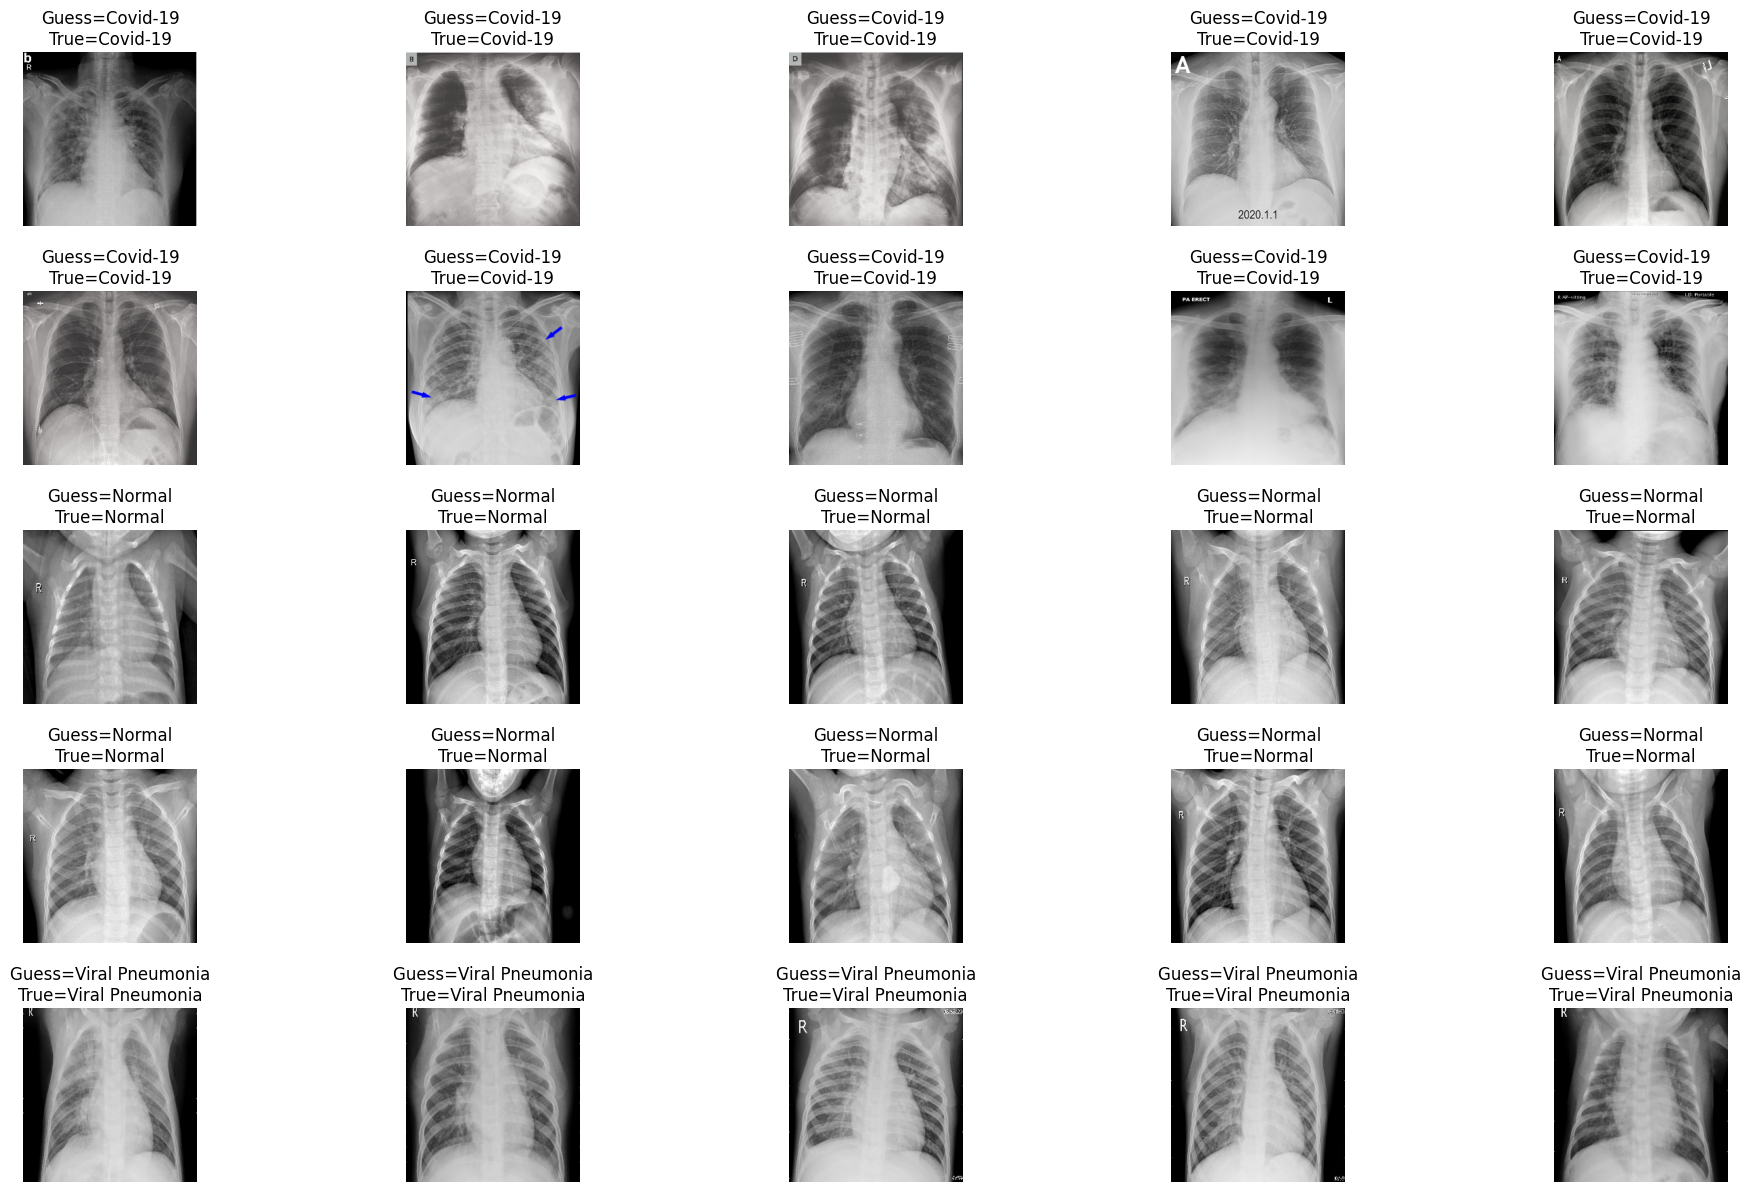

In [70]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (22,15))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')
    
plt.subplots_adjust(wspace = 1.2)

In [71]:
# Classification Report

print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.67      1.00      0.80        10
           2       1.00      0.50      0.67        10
           3       0.89      0.80      0.84        10

    accuracy                           0.82        40
   macro avg       0.87      0.82      0.82        40
weighted avg       0.87      0.82      0.82        40



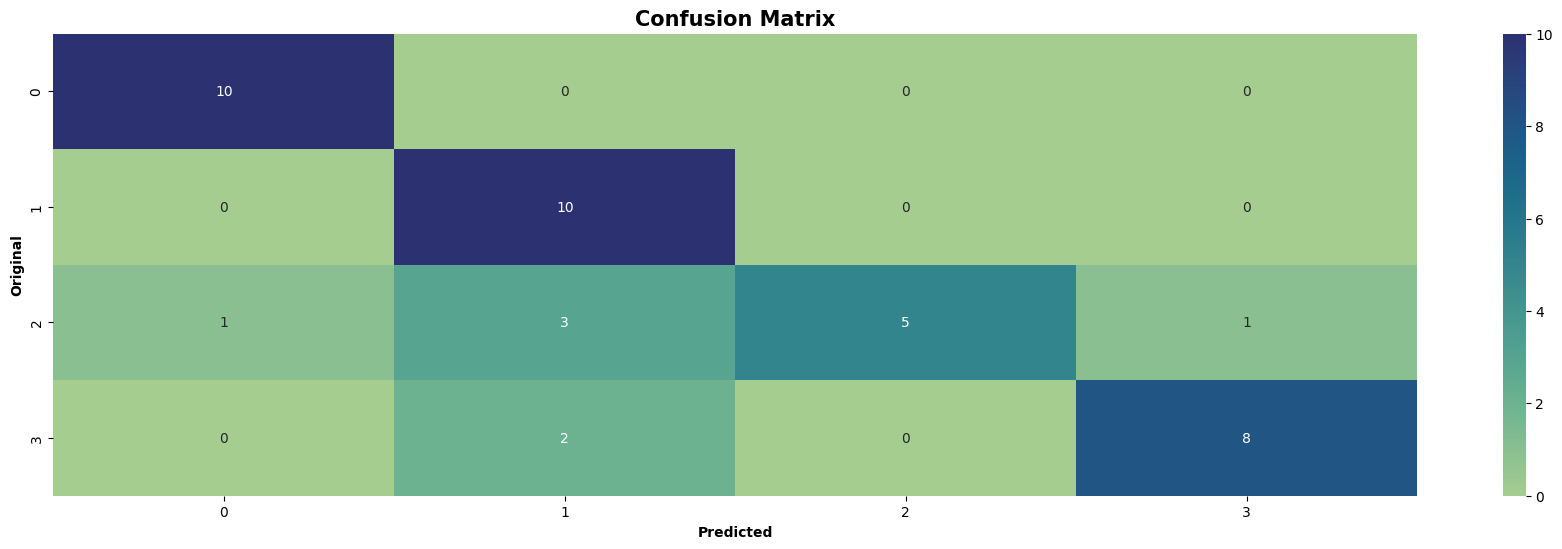

In [78]:
# Confusion Matrix

plt.figure(figsize = (22,6))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'crest')

ax.set_xlabel('Predicted', fontdict = {'weight': 'bold'})
ax.set_ylabel('Original', fontdict = {'weight': 'bold'})
ax.set_title("Confusion Matrix", fontdict = {'weight':'bold', 'size':15})

plt.show()